In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from random import randint
import numpy as np
import matplotlib.pyplot as plt


In [2]:
def get_error( scores , labels ):

    bs=scores.size(0)
    predicted_labels = scores.argmax(dim=1)
    indicator = (predicted_labels == labels)
    num_matches=indicator.sum()
    
    return 1-num_matches.float()/bs    


In [3]:
def show(X):
    if X.dim() == 3 and X.size(0) == 3:
        plt.imshow( np.transpose(  X.numpy() , (1, 2, 0))  )
        plt.show()
    elif X.dim() == 2:
        plt.imshow(   X.numpy() , cmap='gray'  )
        plt.show()
    else:
        print('WRONG TENSOR SIZE')

In [4]:
def show_prob_mnist(p):

    p=p.data.squeeze().numpy()

    ft=15
    label = ('zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight','nine')
    #p=p.data.squeeze().numpy()
    y_pos = np.arange(len(p))*1.2
    target=2
    width=0.9
    col= 'blue'
    #col='darkgreen'

    plt.rcdefaults()
    fig, ax = plt.subplots()

    # the plot
    ax.barh(y_pos, p, width , align='center', color=col)

    ax.set_xlim([0, 1.3])
    #ax.set_ylim([-0.8, len(p)*1.2-1+0.8])

    # y label
    ax.set_yticks(y_pos)
    ax.set_yticklabels(label, fontsize=ft)
    ax.invert_yaxis()  
    #ax.set_xlabel('Performance')
    #ax.set_title('How fast do you want to go today?')

    # x label
    ax.set_xticklabels([])
    ax.set_xticks([])
    #x_pos=np.array([0, 0.25 , 0.5 , 0.75 , 1])
    #ax.set_xticks(x_pos)
    #ax.set_xticklabels( [0, 0.25 , 0.5 , 0.75 , 1] , fontsize=15)

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_linewidth(4)


    for i in range(len(p)):
        str_nb="{0:.2f}".format(p[i])
        ax.text( p[i] + 0.05 , y_pos[i] ,str_nb ,
                 horizontalalignment='left', verticalalignment='center',
                 transform=ax.transData, color= col,fontsize=ft)



    plt.show()
    #fig.savefig('pic/prob', dpi=96, bbox_inches="tight")

In [5]:
import os.path
def check_mnist_dataset_exists(path_data='../../data/'):
    flag_train_data = os.path.isfile(path_data + 'mnist/train_data.pt') 
    flag_train_label = os.path.isfile(path_data + 'mnist/train_label.pt') 
    flag_test_data = os.path.isfile(path_data + 'mnist/test_data.pt') 
    flag_test_label = os.path.isfile(path_data + 'mnist/test_label.pt') 
    if flag_train_data==False or flag_train_label==False or flag_test_data==False or flag_test_label==False:
        print('MNIST dataset missing - downloading...')
        import torchvision
        import torchvision.transforms as transforms
        trainset = torchvision.datasets.MNIST(root=path_data + 'mnist/temp', train=True,
                                                download=True, transform=transforms.ToTensor())
        testset = torchvision.datasets.MNIST(root=path_data + 'mnist/temp', train=False,
                                               download=True, transform=transforms.ToTensor())
        train_data=torch.Tensor(60000,28,28)
        train_label=torch.LongTensor(60000)
        for idx , example in enumerate(trainset):
            train_data[idx]=example[0].squeeze()
            train_label[idx]=example[1]
        torch.save(train_data,path_data + 'mnist/train_data.pt')
        torch.save(train_label,path_data + 'mnist/train_label.pt')
        test_data=torch.Tensor(10000,28,28)
        test_label=torch.LongTensor(10000)
        for idx , example in enumerate(testset):
            test_data[idx]=example[0].squeeze()
            test_label[idx]=example[1]
        torch.save(test_data,path_data + 'mnist/test_data.pt')
        torch.save(test_label,path_data + 'mnist/test_label.pt')
    return path_data

Download the data and print the sizes

In [6]:
data_path=check_mnist_dataset_exists()

train_data=torch.load(data_path+'mnist/train_data.pt')
train_label=torch.load(data_path+'mnist/train_label.pt')
test_data=torch.load(data_path+'mnist/test_data.pt')
test_label=torch.load(data_path+'mnist/test_label.pt')

MNIST dataset missing - downloading...
Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ../../data/mnist/temp/MNIST/raw/train-images-idx3-ubyte.gz to ../../data/mnist/temp/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ../../data/mnist/temp/MNIST/raw/train-labels-idx1-ubyte.gz to ../../data/mnist/temp/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ../../data/mnist/temp/MNIST/raw/t10k-images-idx3-ubyte.gz to ../../data/mnist/temp/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ../../data/mnist/temp/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../../data/mnist/temp/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Make a ONE layer net class.

In [7]:
class one_layer_net(nn.Module):

    def __init__(self, input_size, output_size):
        super(one_layer_net , self).__init__()
        self.linear_layer = nn.Linear( input_size, output_size , bias=False)
        
    def forward(self, x):
        scores = self.linear_layer(x)
        return scores

Build the net

In [8]:
net=one_layer_net(784,10)
print(net)

one_layer_net(
  (linear_layer): Linear(in_features=784, out_features=10, bias=False)
)


Choose the criterion, optimizer, batchsize, learning rate

In [9]:
criterion = nn.CrossEntropyLoss()

optimizer=torch.optim.SGD( net.parameters() , lr=0.01 )

bs=200

Do 30 passes through the training set

In [10]:
for epoch in range(30):
    
    running_loss=0
    running_error=0
    num_batches=0
    
    shuffled_indices=torch.randperm(60000)
 
    for count in range(0,60000,bs):
    
        optimizer.zero_grad()
        
        indices=shuffled_indices[count:count+bs]
        minibatch_data =  train_data[indices]
        minibatch_label= train_label[indices]

        inputs = minibatch_data.view(bs,784)

        inputs.requires_grad_()

        scores=net( inputs ) 

        loss =  criterion( scores , minibatch_label) 
        
        loss.backward()

        optimizer.step()
        
        
        # compute and accumulate stats
        
        running_loss += loss.detach().item()
               
        error = get_error( scores.detach() , minibatch_label)
        running_error += error.item()
        
        num_batches+=1
    
    
    # compute stats for the full training set
    total_loss = running_loss/num_batches
    total_error = running_error/num_batches
    
    print('epoch=',epoch, '\t loss=', total_loss , '\t error=', total_error*100 ,'percent')

epoch= 0 	 loss= 1.436076166431109 	 error= 27.303333342075348 percent
epoch= 1 	 loss= 0.8484666373332341 	 error= 16.595000008742016 percent
epoch= 2 	 loss= 0.6837033667167027 	 error= 14.893333156903585 percent
epoch= 3 	 loss= 0.6036330841978391 	 error= 13.95499990383784 percent
epoch= 4 	 loss= 0.5548386893669764 	 error= 13.35333329439163 percent
epoch= 5 	 loss= 0.5214760946234067 	 error= 12.895000040531157 percent
epoch= 6 	 loss= 0.4968543027838071 	 error= 12.506666620572407 percent
epoch= 7 	 loss= 0.47783838311831156 	 error= 12.213333189487457 percent
epoch= 8 	 loss= 0.4625524421532949 	 error= 11.940000096956888 percent
epoch= 9 	 loss= 0.4499321021636327 	 error= 11.723333458105722 percent
epoch= 10 	 loss= 0.4392983070015907 	 error= 11.536666909853617 percent
epoch= 11 	 loss= 0.43023310552040733 	 error= 11.355000138282776 percent
epoch= 12 	 loss= 0.4222370679179827 	 error= 11.22000022729238 percent
epoch= 13 	 loss= 0.4152680625518163 	 error= 11.08333349227905

Now that the network is trained and do 10% of error on the training set, we are going to see how well it is doing on the test set...

In [11]:
running_error=0
num_batches=0


for i in range(0,10000,bs):

    # extract the minibatch
    minibatch_data =  test_data[i:i+bs]
    minibatch_label= test_label[i:i+bs]

    # reshape the minibatch
    inputs = minibatch_data.view(bs,784)

    # feed it to the network
    scores=net( inputs ) 

    # compute the error made on this batch
    error = get_error( scores , minibatch_label)
    
    # add it to the running error
    running_error += error.item()

    num_batches+=1


    
# compute error rate on the full test set
total_error = running_error/num_batches

print( 'error rate on test set =', total_error*100 ,'percent')


error rate on test set = 9.199999928474426 percent


Choose image at random from the test set and see how good/bad are the predictions

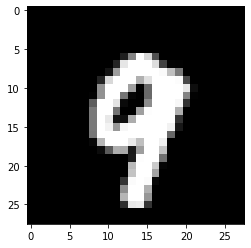

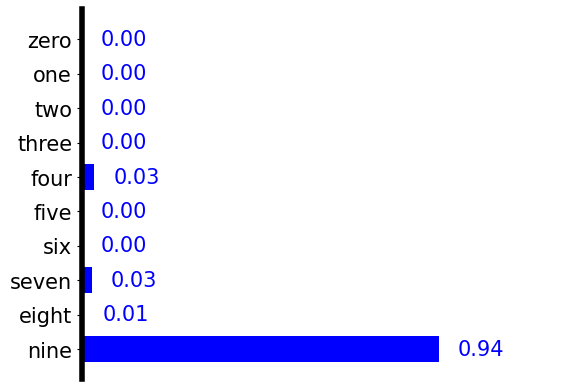

In [12]:
# choose a picture at random
idx=randint(0, 10000-1)
im=test_data[idx]

# diplay the picture
show(im)

# feed it to the net and display the confidence scores
scores =  net( im.view(1,784)) 
probs= F.softmax(scores, dim=1)
show_prob_mnist(probs)